In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import rcParams
import numpy as np
from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import scipy.stats as sts

import scipy.io as sio
import pickle

import pandas as pd

from scipy.signal import savgol_filter

from roiVisualization import myAxisTheme

In [2]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [3]:
def interpFrames(rawDat, FG, fpv, t, framegrab, tVR):

    interpDat = np.zeros((FG[1]-FG[0], 1))
    
    for i in range(FG[0],FG[1]):
        
        iMatch = np.where( t >= ( t[0] + (framegrab[(i-1)*fpv+1] - tVR[0])/10000 ) )[0][0]
        interpDat[i - FG[0]] = rawDat[iMatch]
    
    return interpDat


# Parse matlab data and align treadmill and imaging data
def parseMatPosdat(matdat, fpv):
    
    # Parse matlab data
    tmtime = np.ndarray.flatten(matdat[0,0][0])
    vrtime = np.ndarray.flatten(matdat[0,0][15][0])
    tFrameGrab = np.ndarray.flatten(matdat[0,0][14][0])

    vrOffsets = np.zeros((3, len(tmtime))) # offsetRot, offsetFwd, offsetLat
    for i in range(3):
        vrOffsets[i,:] = np.ndarray.flatten(matdat[0,0][i+1])
    
    tmdeltas = np.zeros((4, len(tmtime))) #dx0, dx1, dy0, dy1
    for i in range(4):
        tmdeltas[i,:] = np.ndarray.flatten(matdat[0,0][i+4])
    
    # Align treadmill and imaging data
    minFG = np.floor(np.where(tFrameGrab >= vrtime[0])[0][0]/fpv)
    maxFG = np.round(len(tFrameGrab)/fpv)
    FG = (int(minFG), int(maxFG))
    
    time = tFrameGrab[0::fpv]/10000
    time = time[FG[0]:FG[1]]

    tmtimeMatch = np.ndarray.flatten(interpFrames(tmtime,FG, fpv, tmtime, tFrameGrab, vrtime)) 
    vrOffsetsMatch = np.zeros((3, len(time))) 
    for i in range(3):
        vrOffsetsMatch[i,:] = np.ndarray.flatten(interpFrames(vrOffsets[i,:],FG, fpv, tmtime, tFrameGrab, vrtime))

    tmdeltasMatch = np.zeros((4, len(time))) 
    for i in range(4):
        tmdeltasMatch[i,:] = np.ndarray.flatten(interpFrames(tmdeltas[i,:],FG, fpv, tmtime, tFrameGrab, vrtime))

    # Compute velocities
    vRot = np.hstack((0,np.diff(vrOffsetsMatch[0,:])/np.diff(time)))*np.pi/180.
    vFwd = np.hstack((0,np.diff(vrOffsetsMatch[1,:])/np.diff(time)))
    vLat = np.hstack((0,np.diff(vrOffsetsMatch[2,:])/np.diff(time)))

    vTrans = np.hypot(vrOffsetsMatch[1,:], vrOffsetsMatch[2,:])*10
    vTrans = np.hstack((0,abs(np.diff(vTrans))/np.diff(time)))

    #package in dictionary
    posDat = {
        'time': time,
        'tmtime': tmtimeMatch,
        'heading': vrOffsetsMatch[0,:]*np.pi/180.,
        'xpos': vrOffsetsMatch[1,:],
        'ypos': vrOffsetsMatch[2,:],
        'vRot': vRot,
        'vFwd': vFwd,
        'vLat': vLat,
        'vTrans': vTrans
    }
    
    return posDat, tmdeltasMatch, FG


def filterVelos(vrDat, window, order):

    vTransFilt= savgol_filter(vrDat['vTrans'], window, order)
    vRotFilt= savgol_filter(vrDat['vRot'], window, order)
    vFwdFilt= savgol_filter(vrDat['vFwd'], window, order)
    vLatFilt= savgol_filter(vrDat['vLat'], window, order)
    #osRotMatch = np.hstack((osRotMatch[0], np.diff(savgol_filter(np.cumsum(osRotMatch), window, order))))

    return vTransFilt, vRotFilt, vFwdFilt, vLatFilt

#
def computePVA (locs, weights):
    """ Compute population vector average
    """
    nsteps = weights.shape[0]
    nvol = weights.shape[1]
    pva_x = np.cos(np.reshape(np.tile(locs,nvol),[nvol,nsteps])).T*weights
    pva_y = np.sin(np.reshape(np.tile(locs,nvol),[nvol,nsteps])).T*weights
    
    pva = np.vstack((sum(pva_x)/len(pva_x), sum(pva_y)/len(pva_x)))
    return pva

In [4]:
# visualisation

def plotDFFROIs (axs, numROIs, ROIdat, roitime):
    #cax = axs.imshow(ROIdat,cmap='Blues', aspect=20, interpolation='None', origin='lower', vmin=0)
    cax = axs.pcolor(roitime,np.arange(0,numROIs+1),ROIdat,cmap='Blues', edgecolors='face')
    axs.set_xlabel('Time [s]')
    axs.set_ylabel('\nROIs (n = {0})'.format(numROIs))
    myAxisTheme(axs)

    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    cbar.set_label('$(F - F_0) / F_0$ (per ROI)')  # vertically oriented colorbar

def plotDFF_PVA_heading_fwdvelo(axs, vrDat, ROIdatMatch, pvaMatch, vTransFilt, numROIs):
    cax = axs[0].pcolor(vrDat['time'],np.arange(0,numROIs+1),ROIdatMatch[2:],cmap='Blues', edgecolors='face')
    axs[0].set_ylabel('\nROIs (n = {0})'.format(numROIs))
    axs[0].plot(vrDat['time'],pvaMatch['pvaROI'],'-', color='black', linewidth=1, alpha=0.5, label='PVA direction')
    axs[0].legend(loc=1)

    axs[1].plot(vrDat['time'],pvaMatch['pvaRad'],color='steelblue', label='PVA direction')
    axs[1].plot(vrDat['time'],vrDat['heading'],color='black', label='absolute heading')
    axs[1].set_ylabel('Radians')
    axs[1].legend(loc=1)

    NOsignal = np.sum(ROIdatMatch[:2], axis=0)
    axs[2].plot(vrDat['time'],NOsignal,color='steelblue', label='NO signal')
    axs[2].plot(vrDat['time'],vTransFilt,color='black', label='filt transl. velocity')
    #axs[2].set_ylim(0,1.5)
    axs[2].set_ylabel('Trans. velocity [cm/s] (black)\nNO signal (DFF)')
    axs[2].set_xlabel('Time [s]')
    
    for ax in axs:
        myAxisTheme(ax)
        ax.set_xlim(vrDat['time'][0],vrDat['time'][-1])
        
def plotPVAerror(axs, vrDat, pvaMatch):
    # align PVA and heading  ## TODO: Replace with correlation analysis...
    pvaAligned = np.mod(np.unwrap(pvaMatch['pvaRad']) - pvaMatch['pvaRad'][0]+np.pi, 2*np.pi)-np.pi
    headingAligned = np.mod(np.unwrap(vrDat['heading']) - vrDat['heading'][0] + np.pi, 2*np.pi)-np.pi

    error = abs(headingAligned-pvaAligned)
    errorUW = abs((np.unwrap(vrDat['heading'])-vrDat['heading'][0]) - (np.unwrap(pvaMatch['pvaRad'])-pvaMatch['pvaRad'][0]))

    axs[0].plot(vrDat['time'],pvaAligned,'-', color='royalblue', label='PVA')
    axs[0].plot(vrDat['time'],headingAligned,'-', color='black', label='heading')

    axs[1].plot(vrDat['time'],np.unwrap(pvaAligned),'-', color='royalblue', label='PVA')
    axs[1].plot(vrDat['time'],np.unwrap(headingAligned),'-', color='black', label='heading')
    axs[1].legend(loc=0)

    axs[2].plot(vrDat['time'],error,'-', color='grey', label='error on wrapped')
    axs[2].plot(vrDat['time'],errorUW,'-', color='midnightblue', label='error on unwrapped')
    axs[2].legend(loc=0)

    for ax in axs:
        myAxisTheme(ax)
        ax.set_xlim(vrDat['time'][0], vrDat['time'][-1])

In [5]:
def myxcorr(x,y,lags):
    cc = np.zeros((len(lags)))
    for i, lag in enumerate(lags):
        if lag < 0:
            cc[i] = np.correlate(x[:lag], y[-lag:])
        elif lag == 0:
            cc[i] = np.correlate(x, y)
        else:
            cc[i] = np.correlate(x[lag:], y[:-lag])
    return cc

def myxcorrCoeff_old(x,y,lags):
    cc = np.zeros((len(lags)))
    for i, lag in enumerate(lags):
        if lag < 0:
            cc[i] = np.cov(x[:lag], y[-lag:])[0,1]/(np.std(x[:lag])*np.std(y[-lag:]))
        elif lag == 0:
            cc[i] = np.cov(x, y)[0,1]/(np.std(x)*np.std(y))
        else:
            cc[i] = np.cov(x[lag:], y[:-lag])[0,1]/(np.std(x[lag:])*np.std(y[:-lag]))
    return cc

def myxcorrCoeff(x,y,lags):
    cc = np.zeros((len(lags)))
    for i, lag in enumerate(lags):
        if lag < 0:
            cc[i] = sts.pearsonr(x[:lag], y[-lag:])[0]
        elif lag == 0:
            cc[i] = sts.pearsonr(x, y)[0]
        else:
            cc[i] = sts.pearsonr(x[lag:], y[:-lag])[0]
    return cc

def myxcorrCoeffPval(x,y,lags):
    cc = np.zeros((len(lags)))
    pvals = np.zeros((len(lags)))
    for i, lag in enumerate(lags):
        if lag < 0:
            cc[i] = sts.pearsonr(x[:lag], y[-lag:])[0]
            pvals[i] = sts.pearsonr(x[:lag], y[-lag:])[1]
        elif lag == 0:
            cc[i] = sts.pearsonr(x, y)[0]
            pvals[i] = sts.pearsonr(x, y)[1]
        else:
            cc[i] = sts.pearsonr(x[lag:], y[:-lag])[0]
            pvals[i] = sts.pearsonr(x[lag:], y[:-lag])[1]
    return cc, pvals

### Specify experimental settings and import imaging info from single tif header

In [12]:
dataDir = '/Users/haberkernh/Desktop/PathInteg_withDan/SytOptGCaMP6f_x_37G12'
conditions = ['dark', 'stripe', 'groundPl']
#['blackFlatGround', 'blackFinetexGround', 'stripeFlatGround', 'stripeFinetexGround']
numTrials = 3

In [13]:
minLine = 10
lc = 0
flyID = 'f01'
stem = '37G12_Syt-GCaMP6f_VK5_{}_4-5d_FB'.format(flyID)

with open(sep.join([dataDir,'rawData','imaging',flyID,''])+ '_'.join([stem, conditions[0],str(1).zfill(5)])+'.tif', 'rb') as fh:
    endofhead = 0 
    fpv = -1
    while(not endofhead):
        line = str(fh.readline()[:-1])
        lc += 1
        # get channel info
        if 'channelSave' in line:
            lineString = str(line)
            if not '[' in lineString: nCh = 1
            else: nCh = int(lineString.split('[')[-1][-2])
        
        if 'scanFrameRate' in line:
            lineString = str(line)
            fpsscan = float(lineString[lineString.find('=')+1:-1])
        
        if 'hFastZ' in line:
            if 'discardFlybackFrames' in line:
                lineString = str(line)
                discardFBFrames = lineString[lineString.find('=')+1:-1]
                
            if 'numDiscardFlybackFrames' in line:
                lineString = str(line)
                nDiscardFBFrames = int(lineString[lineString.find('=')+1:-1])
                
            if 'numFramesPerVolume' in line:
                lineString = str(line)
                fpv = int(lineString[lineString.find('=')+1:-1])
            if 'numVolumes' in line:
                lineString = str(line)
                nVols = int(lineString[lineString.find('=')+1:-1])
        
        if not 'SI' in line and lc > minLine: endofhead = 1
print(' # channels: {}\n fly back? {}\n # discard frames: {}\n # frames/volume: {}\n # volumes: {}'.\
      format(nCh, discardFBFrames, nDiscardFBFrames, fpv, nVols))

caCh = nCh-1
vps =  fpsscan/fpv #volumes per second = fpv / fpsscan
print('frame rate per volume [Hz]: {}'.format(vps))

 # channels: 1
 fly back?  true
 # discard frames: 2
 # frames/volume: 12
 # volumes: 900
frame rate per volume [Hz]: 7.134441666666667


## Preprossessing data from single fly

In [166]:
genotype = '37G12_Syt-GCaMP6f_VK5'
region = 'FB'

In [167]:
flyID = 'f02'
age = '4-5d'
stem = '{}_{}_{}_{}'.format(genotype, flyID, age, region)

FBRois = [0,1,2,3,4,5,6,7]
numRois = 8

plotDir = sep.join([dataDir,'analysis',flyID])

if not exists(sep.join([dataDir,'analysis'])):
    mkdir(sep.join([dataDir,'analysis']))
if not exists(plotDir):
    mkdir(plotDir)
    
preprocsavedir = sep.join([dataDir,'preprocData',flyID,''])

# Collect relevant data across trials in single data frame 
keylist = ['genotype','flyID','age','condition','trial',
            'time','tmtime',
            'heading', 'xpos', 'ypos', 'vRot', 'vFwd', 'vLat', 'vTrans', 
            'vTransFilt', 'vRotFilt', 'vFwdFilt', 'vLatFilt',
            'pvaROI', 'pvaRad', 'pvaLen']
keylist = keylist + ['FB{}'.format(i+1) for i in range(len(FBRois))]
keylist = keylist + ['dffFB{}'.format(i+1) for i in range(len(FBRois))]

#### First collect movement and raw F values from all trials, then compute normalization for DFF (for each trial)

In [168]:
singleFlyDf = pd.DataFrame()

# Parameters for Savitzky-Golay Filter (for velocities and later for DFF)
sgorder = 3
sgwindow = 9

baselines = np.zeros((len(conditions),numTrials, numRois))
        
for cond, condition in enumerate(conditions):
    for trial in range(numTrials):

        datName = '_'.join([stem, condition,str(trial+1).zfill(5)])+'.mat'
        print(datName)

        matDat = sio.loadmat(sep.join([dataDir,'preprocData',flyID,datName]))
        ROIdat = matDat['ROIaveMax']
        veldat = matDat['positionDat']
        numROIs = len(FBRois)

        # preprocess movement data
        vrDat, tmDeltas, FG =  parseMatPosdat(veldat, fpv)

        # filter velocities
        vTransFilt, vRotFilt, vFwdFilt, vLatFilt = filterVelos(vrDat, sgwindow, sgorder)

        # time for imaging and plotting
        #roitime = np.linspace(0, nVols/vps, nVols)

        # collect all raw flourescence data to compute baseline and subsequently DFF over all trials
        ROIdatMatch = ROIdat[:,FG[0]:FG[1]]
        
        # Add values to the data dict
        vrDat['vTransFilt'] = vTransFilt
        vrDat['vRotFilt'] = vRotFilt
        vrDat['vFwdFilt'] = vFwdFilt
        vrDat['vLatFilt'] = vLatFilt
        
        # construct data frame
        singleTrialdf = pd.DataFrame(vrDat)
        singleTrialdf['genotype'] = genotype
        singleTrialdf['flyID'] = flyID
        singleTrialdf['age'] = age
        singleTrialdf['condition'] = condition
        singleTrialdf['trial'] = trial+1

        # add annotated ROI data
        for i in range(len(NORois)):
            singleTrialdf['NO{}'.format(i+1)] = ROIdatMatch[NORois[i],:]-1
            
        for i in range(len(FBRois)):
            singleTrialdf['FB{}'.format(i+1)] = ROIdatMatch[FBRois[i],:]-1
            
        
        # DFF calculation
        baseLinePercent = 5
        offset = 0.0001

        # preprocess imaging data: 
        # (a) Compute DFF from preprocessed ROI data (mean flourescence signal from individual ROIs
        #      after gaussian filtering raw signal). 
        # (b) Savitzky-Golay Filter DFF for each ROI

        for i in range(len(FBRois)):
            Fraw = np.squeeze(singleTrialdf['FB{}'.format(i+1)].values)
            Fraw = savgol_filter(Fraw, sgwindow, sgorder)

            # Estimate baseline
            F0 = np.percentile(Fraw, baseLinePercent)
            if F0 == 0: F0 += offset
            baselines[cond, trial, i] = F0

            # Compute dF/F_0 = (F_raw - F_0)/F_0
            dFF = (Fraw - F0) / F0

            # filter:
            dFFfilt = savgol_filter(dFF, sgwindow, sgorder)

            singleTrialdf['dffFB{}'.format(i+1)] = dFFfilt

            
        singleFlyDf = singleFlyDf.append(singleTrialdf)

37G12_Syt-GCaMP6f_VK5_f02_4-5d_FB_dark_00001.mat
37G12_Syt-GCaMP6f_VK5_f02_4-5d_FB_dark_00002.mat
37G12_Syt-GCaMP6f_VK5_f02_4-5d_FB_dark_00003.mat
37G12_Syt-GCaMP6f_VK5_f02_4-5d_FB_stripe_00001.mat
37G12_Syt-GCaMP6f_VK5_f02_4-5d_FB_stripe_00002.mat
37G12_Syt-GCaMP6f_VK5_f02_4-5d_FB_stripe_00003.mat
37G12_Syt-GCaMP6f_VK5_f02_4-5d_FB_groundPl_00001.mat
37G12_Syt-GCaMP6f_VK5_f02_4-5d_FB_groundPl_00002.mat
37G12_Syt-GCaMP6f_VK5_f02_4-5d_FB_groundPl_00003.mat


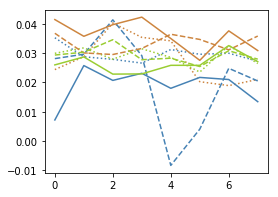

In [169]:
fig, axs = plt.subplots(1,1,figsize=(4,3))
trialCols = ['steelblue', 'peru', 'yellowgreen']
condLine = [':', '--', '-']
for cond, condition in enumerate(conditions):
    for trial in range(numTrials):
        axs.plot(baselines[cond, trial], color=trialCols[trial], linestyle=condLine[cond])

### Compute PVA and add to dataframe

In [170]:
# Compute PVA
roiArcPos = np.linspace(0, 2*np.pi, len(FBRois)+1)[:-1]
roidatFB = np.zeros((len(FBRois),len(singleFlyDf['FB1'].values)))
for i in range(len(FBRois)):
    roidatFB[i,:] = singleFlyDf['FB{}'.format(i+1)].values
pva = computePVA(roiArcPos,roidatFB)
pvaRad = np.arctan2(pva[1,:],pva[0,:])
pvaLen = np.hypot(pva[0,:],pva[1,:])

#TODO: figure out this number automatically!
PVAst = 0
pvaRoi = np.mod((np.unwrap(pvaRad,np.pi) - pvaRad[0]) * numROIs/(2*np.pi) + PVAst, numROIs)

# add some PVA data
singleFlyDf['pvaROI'] = pvaRoi
singleFlyDf['pvaRad'] = pvaRad
singleFlyDf['pvaLen'] = pvaLen

In [171]:
singleFlyDf = singleFlyDf[keylist]
singleFlyDf.to_pickle(preprocsavedir+'singleFlyPreproc_{}_{}_{}.pkl'.format(genotype, flyID, region))

In [172]:
savePlots = False

for cond, condition in enumerate(conditions):
    for trial in range(numTrials):

        # plot DFF over time and save
        if savePlots:
            fig, axs = plt.subplots(1,1,figsize=(12,3))
            plotDFFROIs (axs, numROIs+2, ROIdat, roitime)
            fig.tight_layout()
            fig.savefig(plotDir+sep+stem+'_ROIdata_{}_{}_t{}.pdf'.format(flyID, conditions[cond], trial+1))
            
        if savePlots:
            fig, axs = plt.subplots(3,1, figsize=(12,8),gridspec_kw={'height_ratios':[2,1,1]})
            plotDFF_PVA_heading_fwdvelo(axs, vrDat, ROIdatMatch, pvaMatch, vTransFilt, numROIs)
            fig.tight_layout()
            fig.savefig(plotDir+sep+stem+'_DFF-PVA-heading-fwdvelo_{}_{}_t{}.pdf'.format(flyID, conditions[cond], trial+1))
            
        #if savePlots:
        #    fig, axs = plt.subplots(3,1, figsize=(12,8))
        #    plotPVAerror(axs, vrDat, pvaMatch)
        #    fig.tight_layout()
        #    fig.savefig(plotDir+sep+stem+'_heading-PVA-error_{}_{}_t{}.pdf'.format(flyID, conditions[cond], trial+1))
        

## Compare across conditions, single fly

In [173]:
flyID = 'f02'
age = '4-5d'
stem = '{}_{}_{}'.format(genotype, flyID, region)
pltstem = '{}_{}_{}_{}'.format(genotype, flyID, age, region)
frameNum = 900
vTransTH = 0.1

sgwindow = 11
sgorder = 3

plotDir = sep.join([dataDir,'analysis',flyID])
if not exists(plotDir):
    mkdir(plotDir)
preprocsavedir = sep.join([dataDir,'preprocData',flyID,''])
    
# load data
singleFlydf = pd.read_pickle(preprocsavedir+'singleFlyPreproc_{}.pkl'.format(stem))

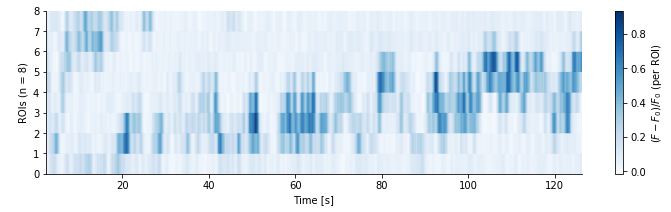

In [174]:
# Sanity check: Plot FB ROIs
subdf = singleFlydf.query('(condition == "{}") & ( trial == {})'.format(conditions[2], 3))

roidatFB = np.zeros((numRois,len(subdf['time'].values)))
for i in range(len(FBRois)):
    roidatFB[i,:] = savgol_filter(subdf['FB{}'.format(i+1)].values,sgwindow, sgorder)
    
fig, axs = plt.subplots(1,1, figsize=(12,3))
cax = axs.pcolor(subdf['time'].values,np.arange(0,numRois+1),roidatFB,cmap='Blues', edgecolors='face')
axs.set_xlabel('Time [s]')
axs.set_ylabel('\nROIs (n = {0})'.format(len(FBRois)))
myAxisTheme(axs)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax)
cbar.set_label('$(F - F_0) / F_0$ (per ROI)')  # vertically oriented colorbar

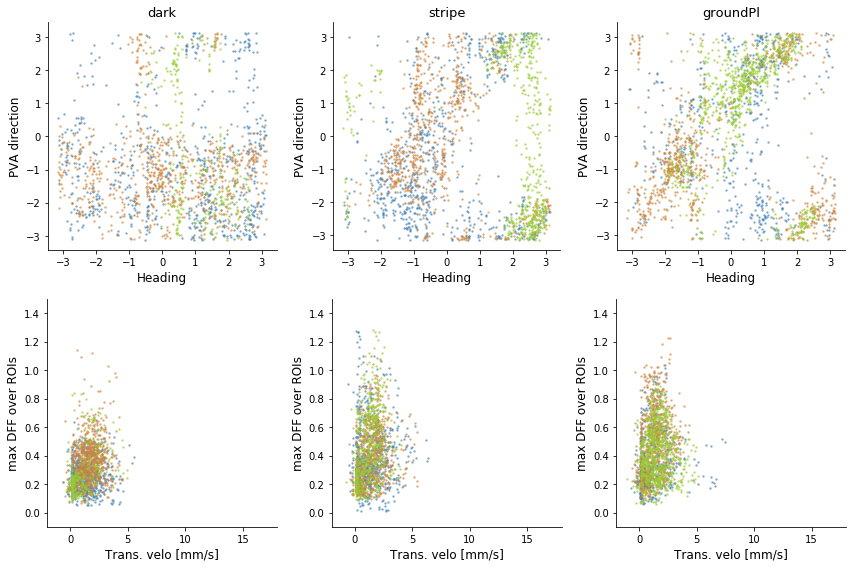

In [175]:
fig, axs = plt.subplots(2,len(conditions), figsize=(12,8))
trialCols = ['steelblue', 'peru', 'yellowgreen']

roiArcPos = np.linspace(0, 2*np.pi, len(FBRois)+1)[:-1]

for cond, condition in enumerate(conditions):
    for trial in range(numTrials):
        
        subdf = singleFlydf.query('(condition == "{}") & ( trial == {}) & (abs(vTransFilt) >= {})'.format(\
                                                        condition, trial+1, vTransTH))
        if len(subdf['time'].values)<0.25*frameNum:
            print('Fly did not move enough')
            continue
        
        roidatFB = np.zeros((numRois,len(subdf['time'].values)))
        for i in range(len(FBRois)):
            roidatFB[i,:] = savgol_filter(subdf['FB{}'.format(i+1)].values,sgwindow, sgorder)
        

        axs[0,cond].plot(subdf['heading'].values,subdf['pvaRad'].values,'.', color=trialCols[trial], alpha=0.5, markersize=3)
        axs[1,cond].plot(subdf['vTransFilt'].values,np.max(roidatFB,axis=0),'.', color=trialCols[trial], alpha=0.5, markersize=3)
        
    axs[0,cond].set_xlabel('Heading', fontsize=12)
    axs[0,cond].set_ylabel('PVA direction', fontsize=12)
    axs[0,cond].set_title(conditions[cond], fontsize=13)
    axs[0,cond].set_aspect('equal')
    axs[1,cond].set_xlabel('Trans. velo [mm/s]', fontsize=12)
    axs[1,cond].set_ylabel('max DFF over ROIs', fontsize=12)
    axs[1,cond].set_xlim(-2,18)
    axs[1,cond].set_ylim(-0.1,1.5)

    for ax in axs[:,cond]:
        myAxisTheme(ax)

fig.tight_layout()
fig.savefig(plotDir+sep+'{}_corrplots.pdf'.format(pltstem))

### Cross correlation plot

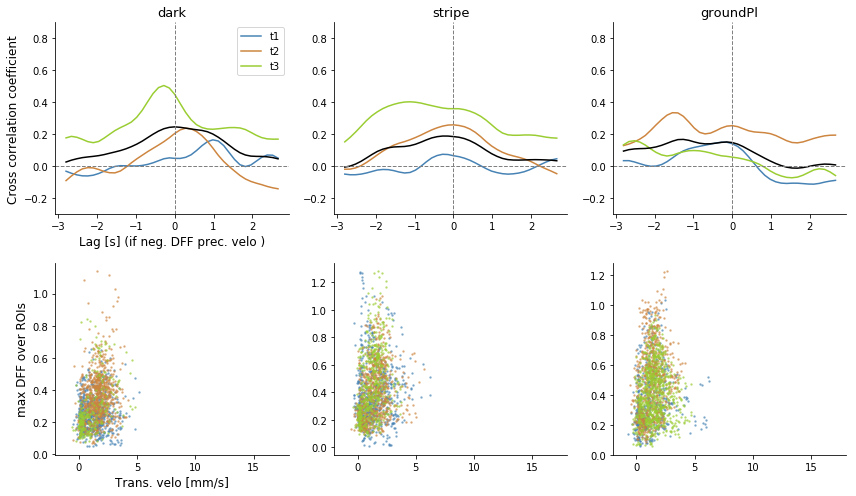

In [176]:
fig, axs = plt.subplots(2,len(conditions), figsize=(12,7))

lags = np.arange(-20, 20)
trialCols = ['steelblue', 'peru', 'yellowgreen']

for cond, condition in enumerate(conditions):
    for trial in range(numTrials):
        subtdf = singleFlydf.query('(condition == "{}") & ( trial == {}) & ( abs(vTransFilt) >= {})'.format(condition, trial+1, vTransTH))
        if len(subtdf['time'].values)<0.25*frameNum:
            print('Fly did not move enough')
            continue
        vTfilt = savgol_filter(subtdf['vTrans'].values, sgwindow, sgorder)
        
        roidatFB = np.zeros((numRois,len(subtdf['time'].values)))
        for i in range(len(FBRois)):
            roidatFB[i,:] = savgol_filter(subtdf['FB{}'.format(i+1)].values,sgwindow, sgorder)
            
        maxF = np.max(roidatFB, axis=0)
        
        # compute cross correlation
        ccVF = myxcorrCoeff(vTfilt,maxF,lags)
        axs[0,cond].plot(lags/vps, ccVF, color=trialCols[trial], label='t'+str(trial+1))   
        
        axs[1,cond].plot(vTfilt, maxF,'.', color=trialCols[trial], alpha=0.5, markersize=3)
        
    subdf = singleFlydf.query('(condition == "{}") & ( abs(vTransFilt) >= {})'.format(condition,vTransTH))
    if len(subdf['time'].values)<0.25*frameNum*3:
        print('Fly did not move enough')
        continue
    
    roidatFB = np.zeros((numRois,len(subdf['time'].values)))
    for i in range(len(FBRois)):
        roidatFB[i,:] = savgol_filter(subdf['FB{}'.format(i+1)].values,sgwindow, sgorder)
    maxF = np.max(roidatFB, axis=0)
        
    vTfilt = savgol_filter(subdf['vTrans'].values, sgwindow, sgorder)
    
    ccVF = myxcorrCoeff(vTfilt,maxF,lags)       
    axs[0,cond].plot(lags/vps, ccVF, color='black')
    
    axs[0,cond].set_title(conditions[cond], fontsize=13)
    axs[0,cond].axvline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
    axs[0,cond].axhline(0,0,1, color='grey', linestyle='dashed', linewidth=1)

axs[0,0].set_ylabel('Cross correlation coefficient', fontsize=12)
axs[0,0].set_xlabel('Lag [s] (if neg. DFF prec. velo )', fontsize=12)
axs[1,0].set_xlabel('Trans. velo [mm/s]', fontsize=12)
axs[1,0].set_ylabel('max DFF over ROIs', fontsize=12)
    
for ax in axs[0,:]:
    myAxisTheme(ax)
    ax.set_ylim(-0.3,0.9)
for ax in axs[1,:]:
    myAxisTheme(ax)
    ax.set_xlim(-2,18)
axs[0,0].legend()

fig.tight_layout()
fig.savefig(plotDir+sep+'{}_crossCorr_vT-maxROIFB.pdf'.format(pltstem))

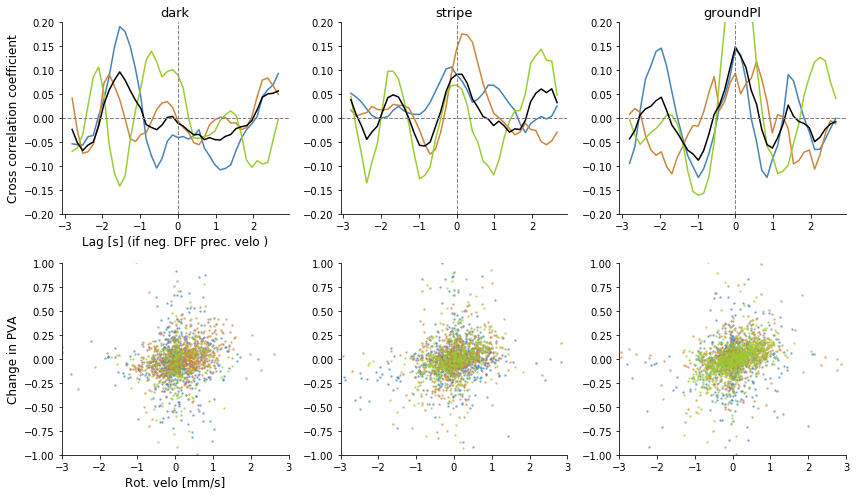

In [177]:
fig, axs = plt.subplots(2,len(conditions), figsize=(12,7))

lags = np.arange(-20, 20)
trialCols = ['steelblue', 'peru', 'yellowgreen']

for cond, condition in enumerate(conditions):
    for trial in range(numTrials):
        subtdf = singleFlydf.query('(condition == "{}") & ( trial == {}) & ( abs(vTransFilt) >= {})'.format(condition, trial+1, vTransTH))
        if len(subtdf['time'].values)<0.25*frameNum:
            print('Fly did not move enough')
            continue

        vfilt = savgol_filter(subtdf['vRot'].values, sgwindow, sgorder)
        
        roidatFB = np.zeros((numRois,len(subtdf['time'].values)))
        for i in range(len(FBRois)):
            roidatFB[i,:] = savgol_filter(subtdf['FB{}'.format(i+1)].values,sgwindow, sgorder)

        pva = computePVA(roiArcPos,roidatFB)
        pvaRad = np.arctan2(pva[1,:],pva[0,:])
        pvaLen = np.hypot(pva[0,:],pva[1,:])
            
        dpva = np.hstack((0,np.diff(np.unwrap(pvaRad))))
        
        # compute cross correlation
        ccVF = myxcorrCoeff(vfilt,dpva,lags)
        axs[0,cond].plot(lags/vps, ccVF, color=trialCols[trial])   
        axs[1,cond].plot(vfilt, dpva,'.', color=trialCols[trial], alpha=0.5, markersize=3)
        
    subdf = singleFlydf.query('(condition == "{}") & ( abs(vTransFilt) >= {})'.format(condition,vTransTH))
    if len(subdf['time'].values)<0.25*frameNum*3:
        print('Fly did not move enough')
        continue
    vfilt = savgol_filter(subdf['vRot'].values, sgwindow, sgorder)
    roidatFB = np.zeros((numRois,len(subdf['time'].values)))
    for i in range(len(FBRois)):
        roidatFB[i,:] = savgol_filter(subdf['FB{}'.format(i+1)].values,sgwindow, sgorder)

    pva = computePVA(roiArcPos,roidatFB)
    pvaRad = np.arctan2(pva[1,:],pva[0,:])
    pvaLen = np.hypot(pva[0,:],pva[1,:])

    dpva = np.hstack((0,np.diff(np.unwrap(pvaRad))))
    
    ccVF = myxcorrCoeff(vfilt,dpva,lags)       
    axs[0,cond].plot(lags/vps, ccVF, color='black')
    
    axs[0,cond].set_title(conditions[cond], fontsize=13)
    axs[0,cond].axvline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
    axs[0,cond].axhline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
axs[0,0].set_ylabel('Cross correlation coefficient', fontsize=12)
axs[0,0].set_xlabel('Lag [s] (if neg. DFF prec. velo )', fontsize=12)
axs[1,0].set_xlabel('Rot. velo [mm/s]', fontsize=12)
axs[1,0].set_ylabel('Change in PVA', fontsize=12)
    
for ax in axs[0,:]:
    myAxisTheme(ax)
    ax.set_ylim(-0.2,0.2)
for ax in axs[1,:]:
    myAxisTheme(ax)
    ax.set_xlim(-3,3)
    ax.set_ylim(-1,1)

fig.tight_layout()
fig.savefig(plotDir+sep+'{}_crossCorr_vR-dPVA.pdf'.format(pltstem))

## Compare cross corr across multiple flies

In [178]:
numFlies = 2

vTransTH = 0.1

sgwindow = 11
sgorder = 3

frameNum = 900

lags = np.arange(-20, 20)

# generate fly color map
cNorm  = colors.Normalize(vmin=-1, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='tab20b')

plotDir = sep.join([dataDir,'analysis'])
if not exists(plotDir):
    mkdir(plotDir)

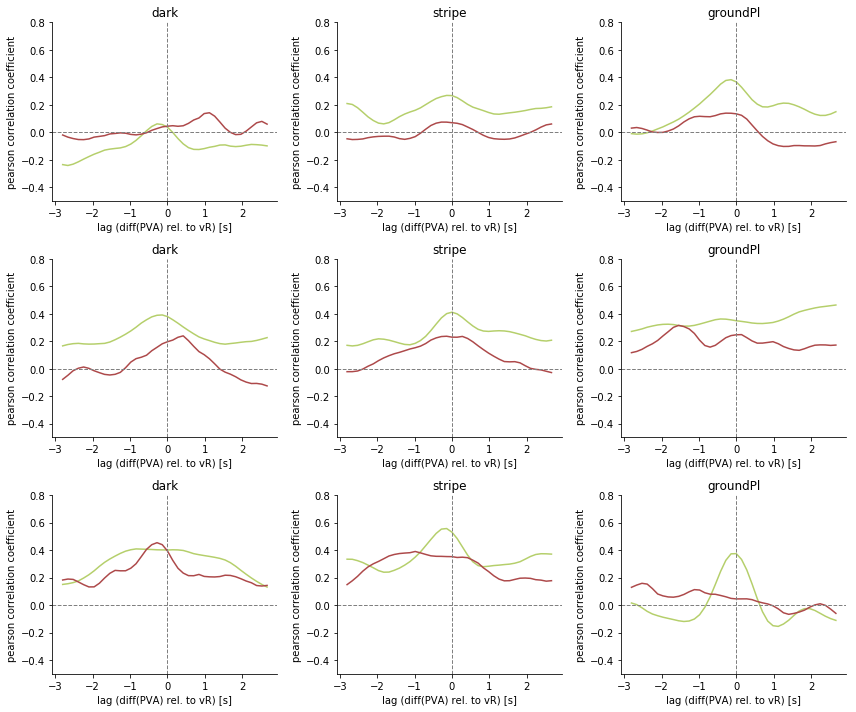

In [184]:
fig, axs = plt.subplots(numTrials,len(conditions), figsize=(12,10))

for fly in range(numFlies):
    # load data
    preprocsavedir = sep.join([dataDir,'preprocData','f0{}'.format(fly+1),''])
    stem = '{}_{}_{}'.format(genotype, 'f0{}'.format(fly+1), region)
    singleFlydf = pd.read_pickle(preprocsavedir+'singleFlyPreproc_{}.pkl'.format(stem))
    
    for cond, condition in enumerate(conditions):
        for trial in range(numTrials):
            subdf = singleFlydf.query('(condition == "{}") & (trial == {}) & ( abs(vTransFilt) >= {})'.format(condition, trial+1, vTransTH))
            if len(subdf['time'].values)<0.25*frameNum:
                continue

            roidatFB = np.zeros((len(FBRois),len(subdf['time'].values)))
            for i in range(len(FBRois)):
                roidatFB[i,:] = subdf['FB{}'.format(i+1)].values

            maxFB = np.max(roidatFB, axis=0)
            vT = savgol_filter(subdf['vTrans'].values, sgwindow, sgorder)
            
            # compute cross correlation
            ccVF, pvals = myxcorrCoeffPval(vT,maxFB,lags) 
            axs[trial,cond].plot(lags/vps, ccVF,label='', color=flyCMap.to_rgba(fly))

for trial in range(numTrials):
    for i, ax in enumerate(axs[trial,:]):
        ax.set_title(conditions[i])
        ax.axvline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        ax.axhline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        ax.set_xlabel('lag (diff(PVA) rel. to vR) [s]')
        ax.set_ylabel('pearson correlation coefficient')
        myAxisTheme(ax)
        ax.set_ylim(-0.5,0.8)

fig.tight_layout()
fig.savefig(plotDir+sep+'{}_{}_crossCorr_vT-maxROIFB.pdf'.format(genotype,region))

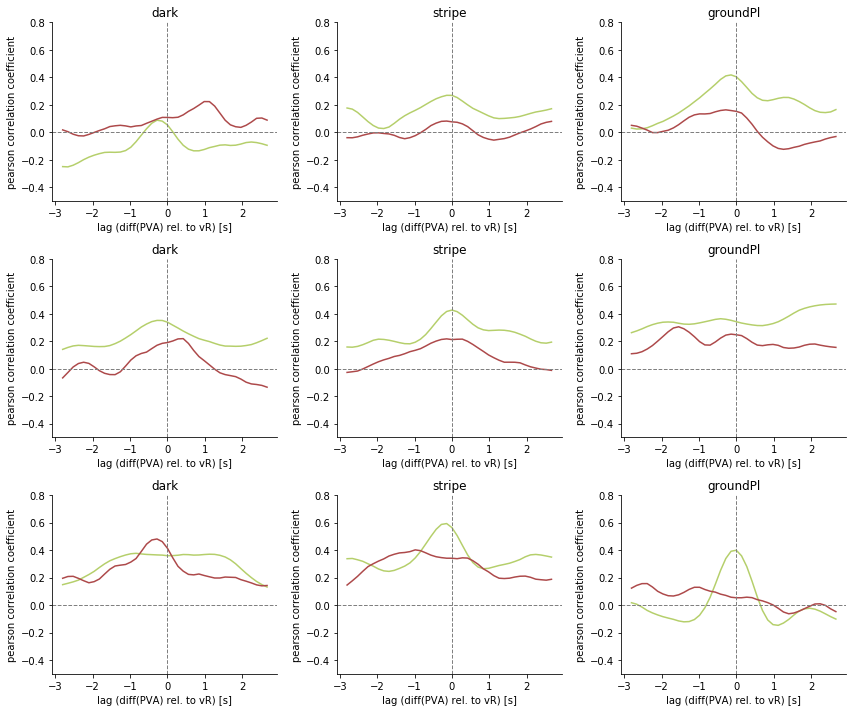

In [187]:
fig, axs = plt.subplots(numTrials,len(conditions), figsize=(12,10))

for fly in range(numFlies):
    # load data
    preprocsavedir = sep.join([dataDir,'preprocData','f0{}'.format(fly+1),''])
    stem = '{}_{}_{}'.format(genotype, 'f0{}'.format(fly+1), region)
    singleFlydf = pd.read_pickle(preprocsavedir+'singleFlyPreproc_{}.pkl'.format(stem))
    
    for cond, condition in enumerate(conditions):
        for trial in range(numTrials):
            subdf = singleFlydf.query('(condition == "{}") & (trial == {}) & ( abs(vTransFilt) >= {})'.format(condition, trial+1, vTransTH))
            if len(subdf['time'].values)<0.25*frameNum:
                continue

            roidatFB = np.zeros((len(FBRois),len(subdf['time'].values)))
            for i in range(len(FBRois)):
                roidatFB[i,:] = subdf['FB{}'.format(i+1)].values

            pva = computePVA(roiArcPos,roidatFB)
            pvaLen = np.hypot(pva[0,:],pva[1,:])

            vT = savgol_filter(subdf['vTrans'].values, sgwindow, sgorder)
            
            # compute cross correlation
            ccVF, pvals = myxcorrCoeffPval(vT,pvaLen,lags) 
            axs[trial,cond].plot(lags/vps, ccVF,label='', color=flyCMap.to_rgba(fly))

for trial in range(numTrials):
    for i, ax in enumerate(axs[trial,:]):
        ax.set_title(conditions[i])
        ax.axvline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        ax.axhline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        ax.set_xlabel('lag (diff(PVA) rel. to vR) [s]')
        ax.set_ylabel('pearson correlation coefficient')
        myAxisTheme(ax)
        ax.set_ylim(-0.5,0.8)

fig.tight_layout()
fig.savefig(plotDir+sep+'{}_{}_crossCorr_vT-PVAlen.pdf'.format(genotype,region))

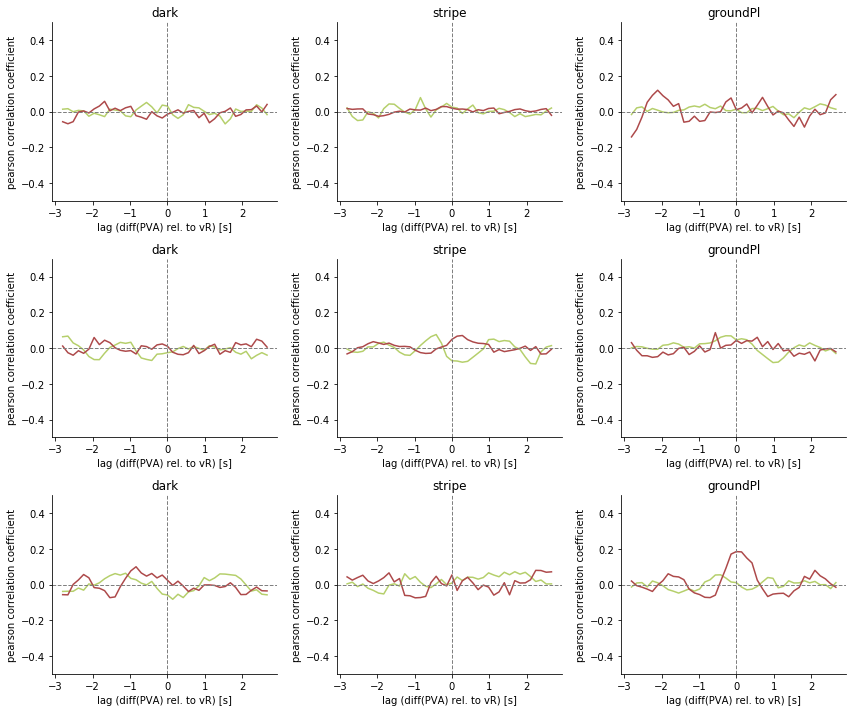

In [185]:
fig, axs = plt.subplots(numTrials,len(conditions), figsize=(12,10))

for fly in range(numFlies):
    # load data
    preprocsavedir = sep.join([dataDir,'preprocData','f0{}'.format(fly+1),''])
    stem = '{}_{}_{}'.format(genotype, 'f0{}'.format(fly+1), region)
    singleFlydf = pd.read_pickle(preprocsavedir+'singleFlyPreproc_{}.pkl'.format(stem))
    
    for cond, condition in enumerate(conditions):
        for trial in range(numTrials):
            subdf = singleFlydf.query('(condition == "{}") & (trial == {}) & ( abs(vTransFilt) >= {})'.format(condition, trial+1, vTransTH))
            if len(subdf['time'].values)<0.25*frameNum:
                continue

            roidatFB = np.zeros((len(FBRois),len(subdf['time'].values)))
            for i in range(len(FBRois)):
                roidatFB[i,:] = subdf['FB{}'.format(i+1)].values

            pva = computePVA(roiArcPos,roidatFB)
            pvaRad = np.arctan2(pva[1,:],pva[0,:])
            pvaLen = np.hypot(pva[0,:],pva[1,:])

            vR = savgol_filter(subdf['vRot'].values, sgwindow, sgorder)
            dpva = np.hstack((0,np.diff(np.unwrap(pvaRad))))
            
            # compute cross correlation
            ccVF, pvals = myxcorrCoeffPval(vR,dpva,lags) 
            axs[trial,cond].plot(lags/vps, ccVF,label='', color=flyCMap.to_rgba(fly))

for trial in range(numTrials):
    for i, ax in enumerate(axs[trial,:]):
        ax.set_title(conditions[i])
        ax.axvline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        ax.axhline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        ax.set_xlabel('lag (diff(PVA) rel. to vR) [s]')
        ax.set_ylabel('pearson correlation coefficient')
        myAxisTheme(ax)
        ax.set_ylim(-0.5,0.5)

fig.tight_layout()
fig.savefig(plotDir+sep+'{}_{}_crossCorr_vR-dPVA.pdf'.format(genotype,region))

## Summary plot

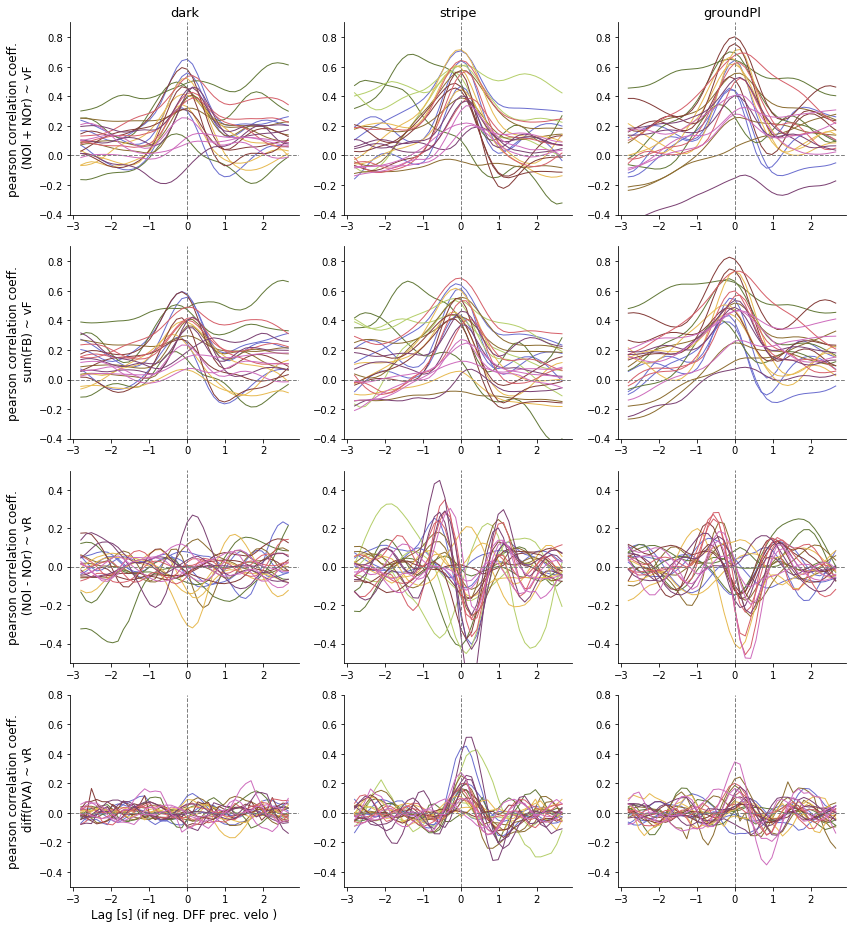

In [37]:
fig, axs = plt.subplots(4,len(conditions), figsize=(12,13))

maxCoeffvT = np.nan*np.ones((2,len(conditions),3,numFlies))
maxCoeffvR = np.nan*np.ones((2,len(conditions),3,numFlies))
minCoeffvR = np.nan*np.ones((2,len(conditions),3,numFlies))

lags = np.arange(-20, 20)


for fly in range(numFlies):
    # load data
    preprocsavedir = sep.join([dataDir,'preprocData','f0{}'.format(fly+1),''])
    stem = '{}_{}_{}'.format(genotype, 'f0{}'.format(fly+1), region)
    singleFlydf = pd.read_pickle(preprocsavedir+'singleFlyPreproc_{}.pkl'.format(stem))
    
    for cond, condition in enumerate(conditions):
        for trial in range(numTrials):
            subdf = singleFlydf.query('(condition == "{}") & (trial == {}) & ( abs(vTransFilt) >= {})'.format(condition, trial+1, vTransTH))
            if len(subdf['NO1'].values)<0.25*frameNum:# or len(subdf['NO1'].values)>=0.95*frameNum:
                continue

            # NO signal
            NOl = savgol_filter(subdf['NO1'].values, sgwindow, sgorder)
            NOr = savgol_filter(subdf['NO2'].values, sgwindow, sgorder)
            vTfilt = savgol_filter(subdf['vTrans'].values, sgwindow, sgorder)
            vRfilt = savgol_filter(subdf['vRot'].values, sgwindow, sgorder)
            NOsig1 = NOl + NOr
            NOsig2 = NOl - NOr
            
            # FB signal (use PVA)
            roidatFB = np.zeros((len(FBRois),len(subdf['time'].values)))
            for i in range(len(FBRois)):
                roidatFB[i,:] = subdf['FB{}'.format(i+1)].values
                roidatFB[i,:]= savgol_filter(roidatFB[i,:], sgwindow, sgorder)

            pva = computePVA(roiArcPos,roidatFB)
            pvaRad = np.arctan2(pva[1,:],pva[0,:])
            pvaLen = np.hypot(pva[0,:],pva[1,:])
            dpvaRad = np.hstack((0,np.diff(np.unwrap(pvaRad))))
            sumFB = np.sum(roidatFB, axis=0)
            
            
            # (A) correlations with translational velo
            # (a) ...with NO signal
            ccVF, pvals = myxcorrCoeffPval(vTfilt,NOsig1,lags) 
            axs[0,cond].plot(lags/vps, ccVF,label='', color=flyCMap.to_rgba(fly), linewidth=1)
            
            maxCoeffvT[0,cond,trial,fly] = np.max(ccVF)
            maxCoeffvT[1,cond,trial,fly] = lags[np.argmax(ccVF)]/vps

            # (b) ...with FB signal
            ccVR, pvals = myxcorrCoeffPval(vTfilt,sumFB,lags) 
            axs[1,cond].plot(lags/vps, ccVR,label='', color=flyCMap.to_rgba(fly), linewidth=1)
            
            # (B) correlations with rotational velo
            # (a) ...with NO signal
            ccVF, pvals = myxcorrCoeffPval(vRfilt,NOsig2,lags) 
            axs[2,cond].plot(lags/vps, ccVF,label='', color=flyCMap.to_rgba(fly), linewidth=1)
            
            maxCoeffvR[0,cond,trial,fly] = np.max(ccVF)
            minCoeffvR[0,cond,trial,fly] = np.min(ccVF)
            
            maxCoeffvR[1,cond,trial,fly] = lags[np.argmax(ccVF)]/vps
            minCoeffvR[1,cond,trial,fly] = lags[np.argmin(ccVF)]/vps
            
            # (b) ...with FB signal
            ccVR, pvals = myxcorrCoeffPval(vRfilt,dpvaRad,lags) 
            axs[3,cond].plot(lags/vps, ccVR,label='', color=flyCMap.to_rgba(fly), linewidth=1)
            

for i in range(len(conditions)):
    axs[0,i].set_title(conditions[i],fontsize=13)
    axs[0,i].set_ylim(-0.4,0.9)
    axs[1,i].set_ylim(-0.4,0.9)
    axs[2,i].set_ylim(-0.5,0.5)
    axs[3,i].set_ylim(-0.5,0.8)
    for ax in axs[:,i]:
        ax.axvline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        ax.axhline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        myAxisTheme(ax)
axs[3,0].set_xlabel('Lag [s] (if neg. DFF prec. velo )', fontsize=12)
axs[0,0].set_ylabel('pearson correlation coeff.\n (NOl + NOr) ~ vF', fontsize=12)
axs[1,0].set_ylabel('pearson correlation coeff.\n sum(FB) ~ vF', fontsize=12)
axs[2,0].set_ylabel('pearson correlation coeff.\n (NOl - NOr) ~ vR', fontsize=12)
axs[3,0].set_ylabel('pearson correlation coeff.\n diff(PVA) ~ vR', fontsize=12)
fig.tight_layout()
fig.savefig(plotDir+sep+'{}_{}_crossCorr_veloDFF_corrPlot_Summary.pdf'.format(genotype,region))

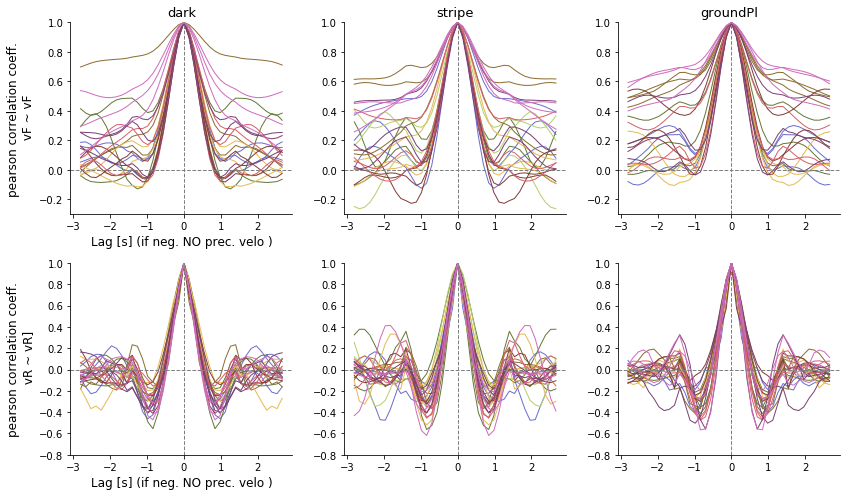

In [704]:
fig, axs = plt.subplots(2,len(conditions), figsize=(12,7))

maxCoeffvT = np.nan*np.ones((2,len(conditions),3,numFlies))
maxCoeffvR = np.nan*np.ones((2,len(conditions),3,numFlies))
minCoeffvR = np.nan*np.ones((2,len(conditions),3,numFlies))

for fly in range(numFlies):
    # load data
    preprocsavedir = sep.join([dataDir,'preprocData','f0{}'.format(fly+1),''])
    stem = '{}_{}_{}'.format(genotype, 'f0{}'.format(fly+1), region)
    singleFlydf = pd.read_pickle(preprocsavedir+'singleFlyPreproc_{}.pkl'.format(stem))
    
    for cond, condition in enumerate(conditions):
        for trial in range(numTrials):
            subdf = singleFlydf.query('(condition == "{}") & (trial == {}) & ( abs(vTransFilt) >= {})'.format(condition, trial+1, vTransTH))
            if len(subdf['NO1'].values)<0.25*frameNum:# or len(subdf['NO1'].values)>=0.95*frameNum:
                continue

            vTfilt = savgol_filter(subdf['vTrans'].values, sgwindow, sgorder)
            vRfilt = savgol_filter(subdf['vRot'].values, sgwindow, sgorder)
            
            # compute cross correlation
            ccVF, pvals = myxcorrCoeffPval(vTfilt,vTfilt,lags) 
            axs[0,cond].plot(lags/vps, ccVF,label='', color=flyCMap.to_rgba(fly), linewidth=1)
            
            maxCoeffvT[0,cond,trial,fly] = np.max(ccVF)
            maxCoeffvT[1,cond,trial,fly] = lags[np.argmax(ccVF)]/vps

            ccVF, pvals = myxcorrCoeffPval(vRfilt,vRfilt,lags) 
            axs[1,cond].plot(lags/vps, ccVF,label='', color=flyCMap.to_rgba(fly), linewidth=1)
            
            maxCoeffvR[0,cond,trial,fly] = np.max(ccVF)
            minCoeffvR[0,cond,trial,fly] = np.min(ccVF)
            
            maxCoeffvR[1,cond,trial,fly] = lags[np.argmax(ccVF)]/vps
            minCoeffvR[1,cond,trial,fly] = lags[np.argmin(ccVF)]/vps

for i in range(len(conditions)):
    axs[0,i].set_title(conditions[i],fontsize=13)
    axs[0,i].set_ylim(-0.3,1)
    axs[1,i].set_ylim(-0.8,1)
    for ax in axs[:,i]:
        ax.axvline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        ax.axhline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        myAxisTheme(ax)
for i in range(2):
    axs[i,0].set_xlabel('Lag [s] (if neg. NO prec. velo )', fontsize=12)
axs[0,0].set_ylabel('pearson correlation coeff.\n vF ~ vF', fontsize=12)
axs[1,0].set_ylabel('pearson correlation coeff.\n vR ~ vR]', fontsize=12)
fig.tight_layout()
fig.savefig(plotDir+sep+'{}_{}_crossCorr_veloAuto_corrPlot_Summary.pdf'.format(genotype,region))

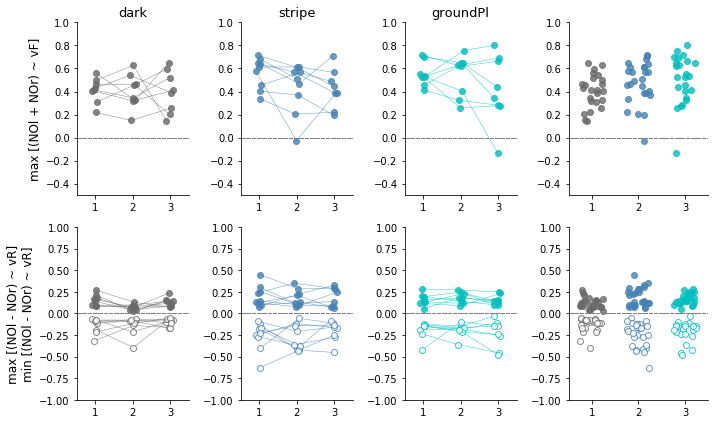

In [699]:
condcol = ['dimgrey', 'steelblue', 'c']
fig, axs = plt.subplots(2,len(conditions)+1, figsize=(10,6), gridspec_kw = {'width_ratios':[1,1,1,1.25]})
jitter = 0.2*(np.random.rand(numTrials,numFlies)-0.5)
for fly in range(numFlies):
    for cond, condition in enumerate(conditions):
        axs[0,cond].plot(range(1,4)+jitter[:,fly], maxCoeffvT[0,cond,:,fly],'-o', color=condcol[cond], linewidth=.5, alpha=0.8)
        axs[0,cond].set_ylim(-.5,1)
        axs[0,cond].set_title(condition,fontsize=13)

        axs[1,cond].plot(range(1,4)+jitter[:,fly], maxCoeffvR[0,cond,:,fly],'-o', color=condcol[cond], linewidth=.5, alpha=0.8)
        axs[1,cond].plot(range(1,4)+jitter[:,fly], minCoeffvR[0,cond,:,fly],'-o', color=condcol[cond], linewidth=.5, alpha=0.8,markerfacecolor="white")
        axs[1,cond].set_ylim(-1,1)

        for i in range(numTrials):
            axs[0,3].plot(cond+1+0.5*(np.random.rand(1)-0.5), maxCoeffvT[0,cond,i,fly],'o', color=condcol[cond], linewidth=.5, alpha=0.8)
            axs[0,3].set_ylim(-.5,1)
            
            axs[1,3].plot(cond+1+0.5*(np.random.rand(1)-0.5), maxCoeffvR[0,cond,i,fly],'o', color=condcol[cond], linewidth=.5, alpha=0.8)
            axs[1,3].plot(cond+1+0.5*(np.random.rand(1)-0.5), minCoeffvR[0,cond,i,fly],'o', color=condcol[cond], linewidth=.5, alpha=0.8,markerfacecolor="white")
            axs[1,3].set_ylim(-1,1)
            
        for i in range(2):
            axs[i,cond].set_xlim(0.5,3.5)
            axs[i,cond].axhline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
            myAxisTheme(axs[i,cond])
            
            axs[i,3].set_xlim(0.5,3.5)
            axs[i,3].axhline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
            myAxisTheme(axs[i,3])
            
            
axs[0,0].set_ylabel('max [(NOl + NOr) ~ vF]', fontsize=12)
axs[1,0].set_ylabel('max [(NOl - NOr) ~ vR]\nmin [(NOl - NOr) ~ vR]', fontsize=12)
fig.tight_layout()
fig.savefig(plotDir+sep+'{}_{}_crossCorr_rossCorr_vT-NO_Summary.pdf'.format(genotype,region))

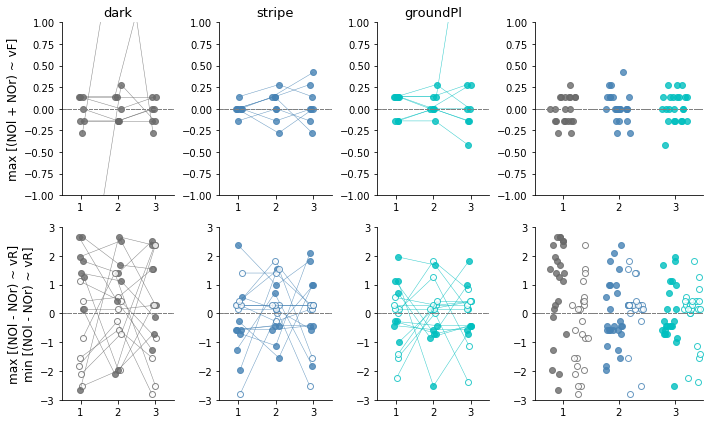

In [700]:
condcol = ['dimgrey', 'steelblue', 'c']
fig, axs = plt.subplots(2,len(conditions)+1, figsize=(10,6), gridspec_kw = {'width_ratios':[1,1,1,1.5]})
jitter = 0.2*(np.random.rand(numTrials,numFlies)-0.5)
for fly in range(numFlies):
    for cond, condition in enumerate(conditions):
        axs[0,cond].plot(range(1,4)+jitter[:,fly], maxCoeffvT[1,cond,:,fly],'-o', color=condcol[cond], linewidth=.5, alpha=0.8)
        axs[0,cond].set_ylim(-1,1)
        axs[0,cond].set_title(condition,fontsize=13)

        axs[1,cond].plot(range(1,4)+jitter[:,fly], maxCoeffvR[1,cond,:,fly],'-o', color=condcol[cond], linewidth=.5, alpha=0.8)
        axs[1,cond].plot(range(1,4)+jitter[:,fly], minCoeffvR[1,cond,:,fly],'-o', color=condcol[cond], linewidth=.5, alpha=0.8,markerfacecolor="white")
        axs[1,cond].set_ylim(-3,3)

        for i in range(numTrials):
            axs[0,3].plot(cond+1+0.5*(np.random.rand(1)-0.5), maxCoeffvT[1,cond,i,fly],'o', color=condcol[cond], linewidth=.5, alpha=0.8)
            axs[0,3].set_ylim(-1,1)
            
            axs[1,3].plot(cond+1+0.3*(np.random.rand(1)-0.8), maxCoeffvR[1,cond,i,fly],'o', color=condcol[cond], linewidth=.5, alpha=0.8)
            axs[1,3].plot(cond+1+0.3*(np.random.rand(1)+0.5), minCoeffvR[1,cond,i,fly],'o', color=condcol[cond], linewidth=.5, alpha=0.8,markerfacecolor="white")
            axs[1,3].set_ylim(-3,3)
            
        for i in range(2):
            axs[i,cond].set_xlim(0.5,3.5)
            axs[i,cond].axhline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
            myAxisTheme(axs[i,cond])
            
            axs[i,3].set_xlim(0.5,3.5)
            axs[i,3].axhline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
            myAxisTheme(axs[i,3])
            
            
axs[0,0].set_ylabel('max [(NOl + NOr) ~ vF]', fontsize=12)
axs[1,0].set_ylabel('max [(NOl - NOr) ~ vR]\nmin [(NOl - NOr) ~ vR]', fontsize=12)
fig.tight_layout()
fig.savefig(plotDir+sep+'{}_{}_crossCorr_rossCorr_vR-NO_Summary.pdf'.format(genotype,region))

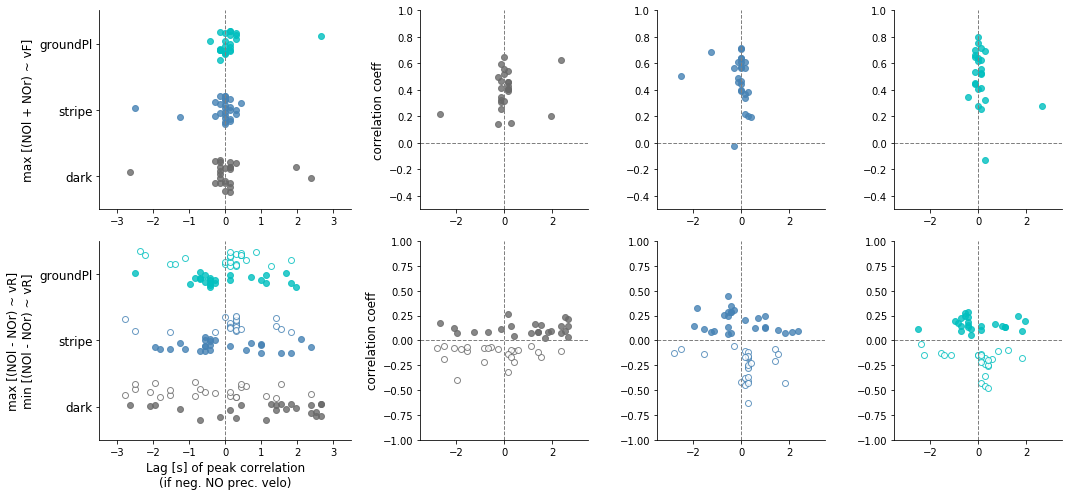

In [701]:
condcol = ['dimgrey', 'steelblue', 'c']
fig, axs = plt.subplots(2,4, figsize=(15,7), gridspec_kw = {'width_ratios':[1.5,1,1,1]})
jitter = 0.2*(np.random.rand(numTrials,numFlies)-0.5)
for fly in range(numFlies):
    for cond, condition in enumerate(conditions):
        for i in range(numTrials):
            axs[0,0].plot(maxCoeffvT[1,cond,i,fly],cond+1+0.5*(np.random.rand(1)-0.5),'o', color=condcol[cond], linewidth=.5, alpha=0.8)
            axs[0,0].set_xlim(-1,1)
            
            axs[1,0].plot(maxCoeffvR[1,cond,i,fly],cond+1+0.25*(np.random.rand(1)-0.8), 'o', color=condcol[cond], linewidth=.5, alpha=0.8)
            axs[1,0].plot(minCoeffvR[1,cond,i,fly],cond+1+0.25*(np.random.rand(1)+0.5), 'o', color=condcol[cond], linewidth=.5, alpha=0.8,markerfacecolor="white")
            
            
            axs[0,1+cond].plot(maxCoeffvT[1,cond,i,fly],maxCoeffvT[0,cond,i,fly],'o', color=condcol[cond], linewidth=.5, alpha=0.8)
            axs[0,1+cond].set_xlim(-1,1)
            
            axs[1,1+cond].plot(maxCoeffvR[1,cond,i,fly],maxCoeffvR[0,cond,i,fly], 'o', color=condcol[cond], linewidth=.5, alpha=0.8)
            axs[1,1+cond].plot(minCoeffvR[1,cond,i,fly],minCoeffvR[0,cond,i,fly], 'o', color=condcol[cond], linewidth=.5, alpha=0.8,markerfacecolor="white")
            
for i in range(2):
    plt.sca(axs[i,0])
    plt.yticks(np.arange(1,len(conditions)+1), conditions, fontsize=12)
    axs[i,0].set_ylim(0.5,3.5)
    for ax in axs[i,:]:
        myAxisTheme(ax)
        ax.set_xlim(-3.5,3.5)
        ax.axvline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
        ax.axhline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
    for i in range(1,4):
        axs[0,i].set_ylim(-0.5,1)
        axs[1,i].set_ylim(-1,1)
axs[1,0].set_xlabel('Lag [s] of peak correlation\n(if neg. NO prec. velo)', fontsize=12)   
axs[0,0].set_ylabel('max [(NOl + NOr) ~ vF]', fontsize=12)
axs[1,0].set_ylabel('max [(NOl - NOr) ~ vR]\nmin [(NOl - NOr) ~ vR]', fontsize=12)
axs[0,1].set_ylabel('correlation coeff', fontsize=12)
axs[1,1].set_ylabel('correlation coeff', fontsize=12)
fig.tight_layout()
fig.savefig(plotDir+sep+'{}_{}_crossCorr_veloNO_peakCorr_Summary.pdf'.format(genotype,region))

#### TODO: use cross correlation to identify the phaseshift that corresponds to the best alignment between the two signals
#### Potentially need a different method, since relationship not necessarily linear (because of imperfections of ROI drawing and potentially individual tuning of neurons)

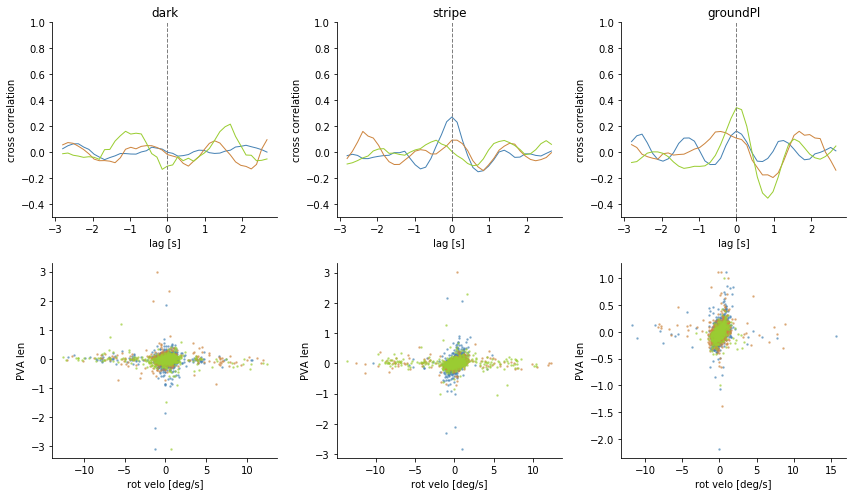

In [727]:
fig, axs = plt.subplots(2,len(conditions), figsize=(12,7))
trialCols = ['steelblue', 'peru', 'yellowgreen']

inds = np.arange(-30,30+1)
window = inds/vps

numPts = ROIdat.shape[1]

for cond, condition in enumerate(conditions):
    for trial in range(numTrials):
        
        subdf = singleFlydf.query('(condition == "{}") & (trial == {}) & ( abs(vTransFilt) >= {})'.format(condition, trial+1, vTransTH))
        
        roidatFB = np.zeros((len(FBRois),len(subdf['time'].values)))
        for i in range(len(FBRois)):
            roidatFB[i,:] = subdf['FB{}'.format(i+1)].values
            roidatFB[i,:]= savgol_filter(roidatFB[i,:], sgwindow, sgorder)

        pva = computePVA(roiArcPos,roidatFB)
        pvaRad = np.arctan2(pva[1,:],pva[0,:])
        pvaLen = np.hypot(pva[0,:],pva[1,:])
        
        vR = savgol_filter(subdf['vRot'].values, sgwindow, sgorder)
        pvaSig = np.hstack((0,np.diff(np.unwrap(pvaRad))))
        
        # compute cross correlation
        ccVF = np.correlate(vR, pvaSig,'same')
        ccVF, pvals = myxcorrCoeffPval(vR, pvaSig,lags) 
        axs[0,cond].plot(lags/vps, ccVF, color=trialCols[trial], linewidth=1)
        axs[1,cond].plot(vR,pvaSig,'.', color=trialCols[trial], alpha=0.5, markersize=3)
        

    axs[0,cond].set_title(conditions[cond])
    axs[0,cond].set_ylim(-0.5, 1)
    axs[0,cond].axvline(0,0,1, color='grey', linestyle='dashed', linewidth=1)
    axs[0,cond].set_xlabel('lag [s]')
    axs[0,cond].set_ylabel('cross correlation')
    
    for ax in axs[:,cond]:

        myAxisTheme(ax)
        
    axs[1,cond].set_xlabel('rot velo [deg/s]')
    axs[1,cond].set_ylabel('PVA len')
        
fig.tight_layout()
#fig.savefig(plotDir+sep+'{}_crossCorr_vT-NO.pdf'.format(stem))

/Users/haberkernh/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


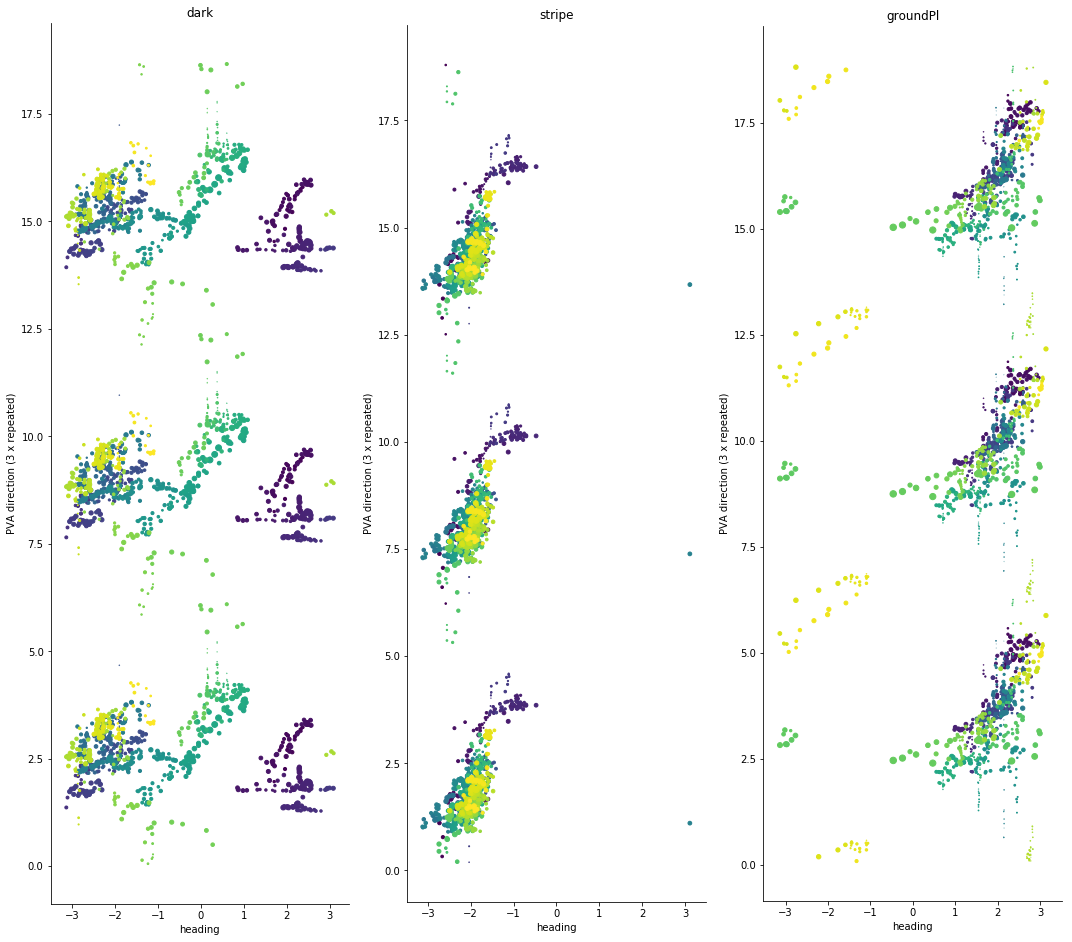

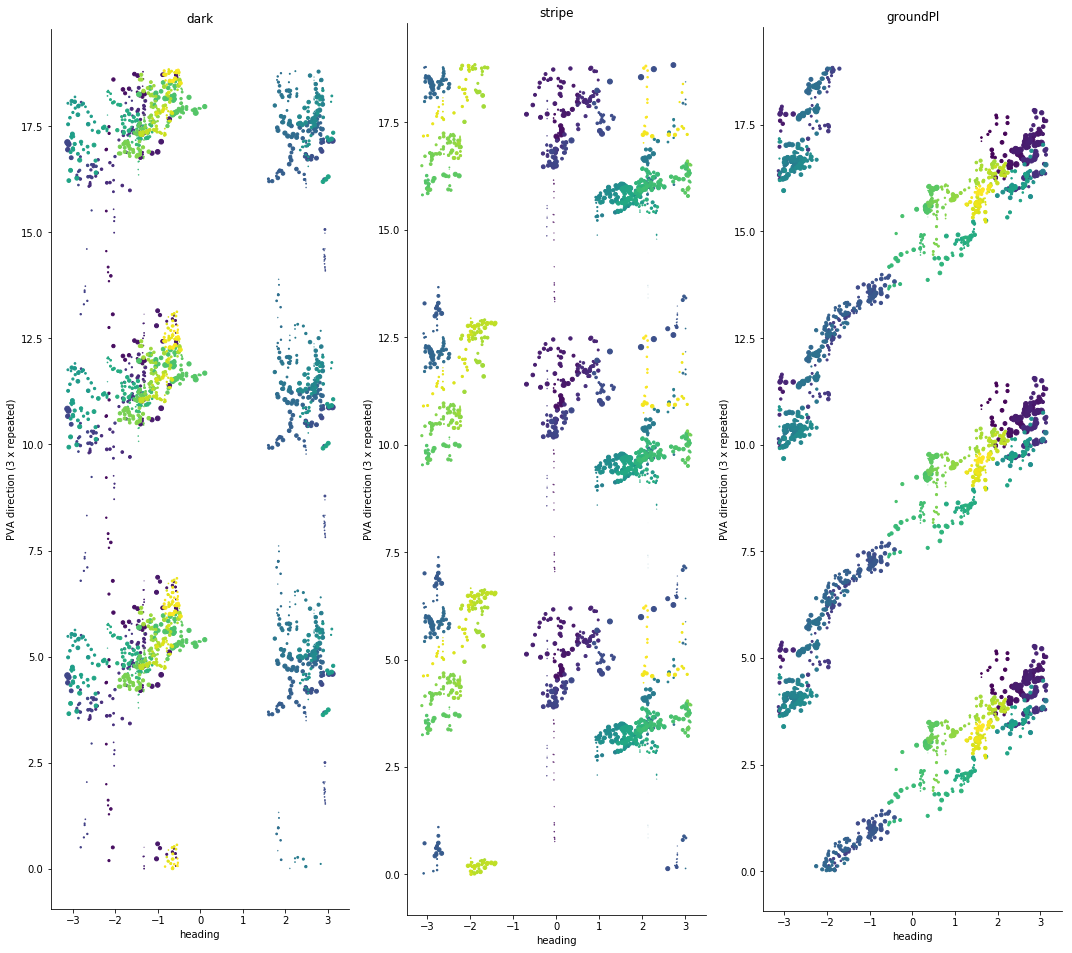

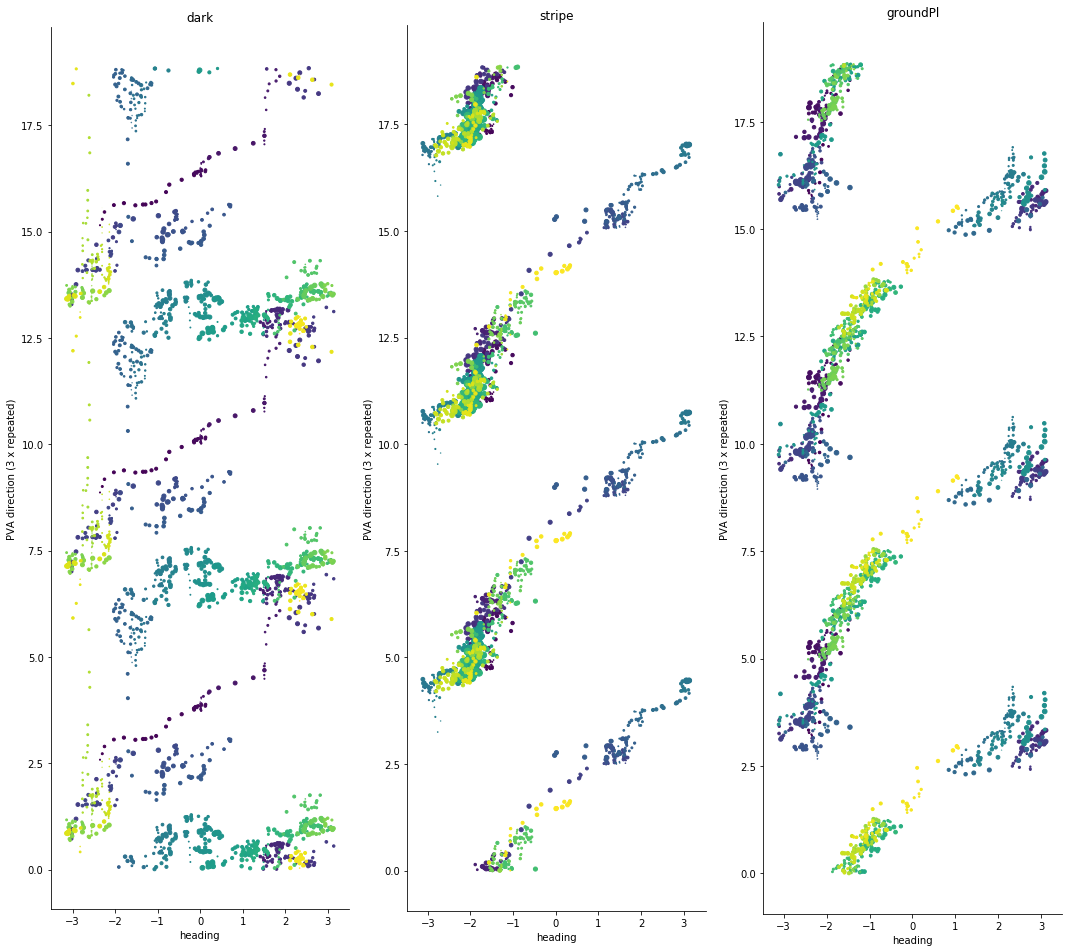

In [61]:
#with plt.style.context(('dark_background')):
for trial in range(numTrials):

    fig, axs = plt.subplots(1,len(conditions), figsize=(15,15))

    for cond, condition in enumerate(conditions):
        
        subdf = singleFlydf.query('(condition == "{}") & ( trial == {})'.format(condition, trial+1))
        NOsig = subdf['NO1'] + subdf['NO2']

        for i in range(3):
            cb = axs[cond].scatter(subdf['heading'], subdf['pvaRad']+(i+0.5)*np.pi*2,
                      s=5*subdf['vTransFilt'],c=subdf['time'], cmap='viridis') #'YlGnBu'

        axs[cond].set_xlabel('heading')
        axs[cond].set_ylabel('PVA direction (3 x repeated)')
        axs[cond].set_title(conditions[cond])
        axs[cond].set_aspect('equal')

    for ax in axs:
        myAxisTheme(ax)

    #plt.colorbar(cb, label='Time [s]')
    fig.tight_layout()
    fig.savefig(plotDir+sep+'heading2PVAMap_darkPlot_{}_t0{}.pdf'.format(flyID, trial+1))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/haberkernh/Desktop/PathInteg_withDan/GCaMP7f_x_SS78/closedLoopStim/preprocData/f01/vrDat_f01_dark_t1.pdf.pkl'

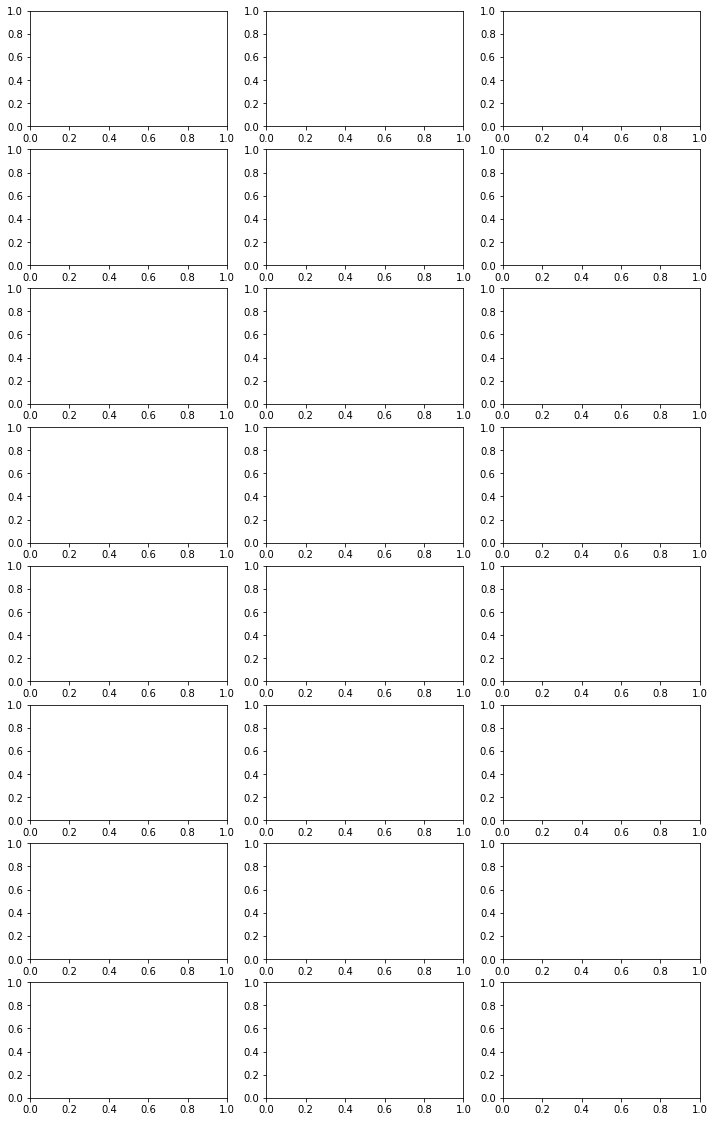

In [62]:
fig, axs = plt.subplots(numROIs,len(conditions), figsize=(12,20))

for cond in range(len(conditions)):

    vt = []
    ROIdat2 = np.zeros((numROIs,1))
    for trial in range(numTrials):
        datStem = '_{}_{}_t{}.pdf'.format(flyID, conditions[cond], trial+1)+'.pkl'
        vrDat = pickle.load( open(sep.join([dataDir,'preprocData',flyID,''])+'vrDat'+datStem, "rb" ) )
        ROIdat = pickle.load( open(sep.join([dataDir,'preprocData',flyID,''])+'ROIdat'+datStem, "rb" ) )
        PVAdat = pickle.load( open(sep.join([dataDir,'preprocData',flyID,''])+'PVAdat'+datStem, "rb" ) )
        
        vt = np.hstack((vt,vrDat['vTransFilt']))
        ROIdat2 = np.hstack((ROIdat2,ROIdat[2:]))
    
    ROIdat2 = ROIdat2[:,1:]
    
    for i in range(ROIdat.shape[0]-2):
        axs[i,cond].plot(vt, ROIdat2[i,:],'.', alpha=0.5, markersize=3)
        axs[i,cond].set_xlim(-0.1,1)

    for ax in axs[:,cond]:
        myAxisTheme(ax)
    axs[0,cond].set_title(conditions[cond])

fig.tight_layout()
#fig.savefig(plotDir+sep+'vtrans2DFFMap_{}.pdf'.format(flyID))    

In [ ]:
import scipy.stats as sts

with plt.style.context(('dark_background')):
    fig, axs = plt.subplots(numROIs,len(conditions), figsize=(8,12))

    for cond in range(len(conditions)):

        vt = []
        h = []
        ROIdat2 = np.zeros((numROIs,1))
        for trial in range(numTrials):
            datStem = '_{}_{}_t{}.pdf'.format(flyID, conditions[cond], trial+1)+'.pkl'
            vrDat = pickle.load( open(sep.join([dataDir,'preprocData',flyID,''])+'vrDat'+datStem, "rb" ) )
            ROIdat = pickle.load( open(sep.join([dataDir,'preprocData',flyID,''])+'ROIdat'+datStem, "rb" ) )
            PVAdat = pickle.load( open(sep.join([dataDir,'preprocData',flyID,''])+'PVAdat'+datStem, "rb" ) )

            vt = np.hstack((vt,vrDat['vTransFilt']))
            h = np.hstack((h,vrDat['heading']))
            ROIdat2 = np.hstack((ROIdat2,ROIdat[2:]))

        ROIdat2 = ROIdat2[:,1:]
        binx = np.linspace(0,1,15)
        biny = np.linspace(-np.pi, np.pi,18)

        for i in range(ROIdat.shape[0]-2):
            ret = sts.binned_statistic_2d(vt, h, ROIdat2[i,:], 'mean', bins=[binx,biny])
            y, x = np.meshgrid(ret.x_edge, ret.y_edge)
            axs[i,cond].pcolormesh(x,y, ret.statistic.T, vmin=1, vmax=2)

        for ax in axs[:,cond]:
            myAxisTheme(ax)
        axs[0,cond].set_title(conditions[cond])
        axs[-1,0].set_xlabel('heading [rad]')
        axs[-1,0].set_ylabel('transl. velo\n[cm/s]')

    fig.tight_layout()
    fig.savefig(plotDir+sep+'heading-Velo-2Dmap_mean_dark_fineScale_v1-2_{}.pdf'.format(flyID))
    

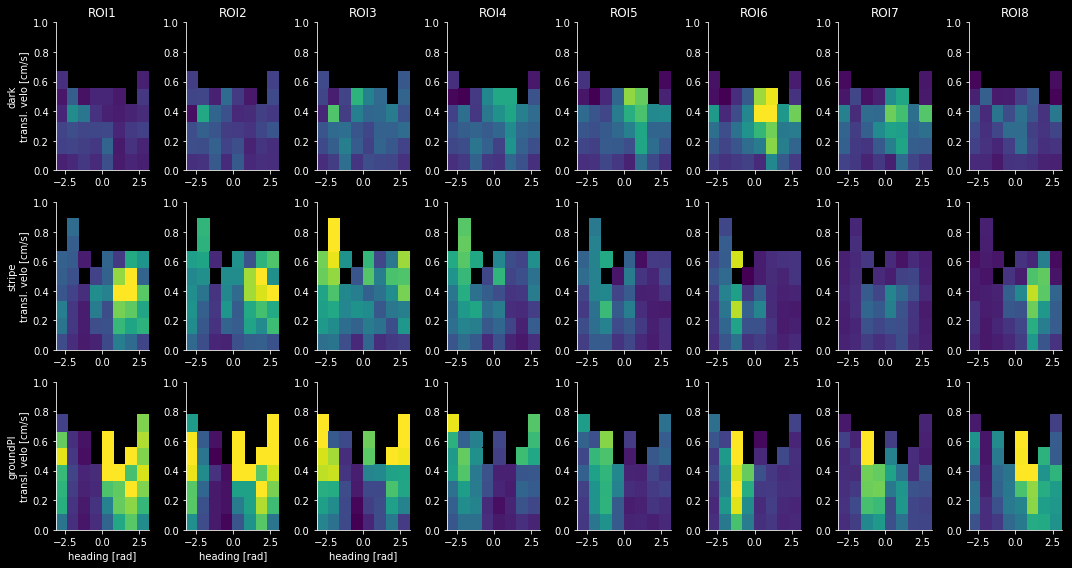

In [64]:
import scipy.stats as sts

with plt.style.context(('dark_background')):
    fig, axs = plt.subplots(len(conditions),numROIs, figsize=(15,8))

    for cond in range(len(conditions)):

        vt = []
        h = []
        ROIdat2 = np.zeros((numROIs,1))
        for trial in range(1,numTrials):
            datStem = '_{}_{}_t{}.pdf'.format(flyID, conditions[cond], trial+1)+'.pkl'
            vrDat = pickle.load( open(sep.join([dataDir,'preprocData',flyID,''])+'vrDat'+datStem, "rb" ) )
            ROIdat = pickle.load( open(sep.join([dataDir,'preprocData',flyID,''])+'ROIdat'+datStem, "rb" ) )
            PVAdat = pickle.load( open(sep.join([dataDir,'preprocData',flyID,''])+'PVAdat'+datStem, "rb" ) )

            vt = np.hstack((vt,vrDat['vTransFilt']))
            h = np.hstack((h,vrDat['heading']))
            ROIdat2 = np.hstack((ROIdat2,ROIdat[2:]))

        ROIdat2 = ROIdat2[:,1:]
        binx = np.linspace(0,1,10)
        biny = np.linspace(-np.pi, np.pi,9)

        for i in range(ROIdat.shape[0]-2):
            ret = sts.binned_statistic_2d(vt, h, ROIdat2[i,:], 'mean', bins=[binx,biny])
            y, x = np.meshgrid(ret.x_edge, ret.y_edge)
            axs[cond,i].pcolormesh(x,y, ret.statistic.T, vmin=1, vmax=2)

            myAxisTheme(axs[cond,i])
            
        for i in range(ROIdat.shape[0]-2):
            axs[0,i].set_title('ROI{}'.format(i+1))
        
        axs[cond,0].set_ylabel(conditions[cond]+'\ntransl. velo [cm/s]')
        axs[-1,cond].set_xlabel('heading [rad]')

    fig.tight_layout()
    fig.savefig(plotDir+sep+'heading-Velo-2Dmap_mean_darkLandscape_{}.pdf'.format(flyID))
    